<a href="https://www.kaggle.com/code/ikram98ai/tiktok-video-claim-classification?scriptVersionId=194677310" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Classifying videos using machine learning**

A machine learning model that can be used to determine whether a video contains a claim or whether it offers an opinion. With a successful prediction model, TikTok can reduce the backlog of user reports and prioritize them more efficiently.

**The purpose** of this model is to mitigate misinformation in videos on the TikTok platform.

**The goal** of this model is to predict whether a TikTok video presents a "claim" or presents an "opinion".


# **PACE stages**


## **Pace: Plan**

**Selecting an evaluation metric**

To determine which evaluation metric might be best, consider how the model might be wrong. There are two possibilities for bad predictions:

  - **False positives:** When the model predicts a video is a claim when in fact it is an opinion
  - **False negatives:** When the model predicts a video is an opinion when in fact it is a claim

The worst case for an opinion misclassified as a claim is that the video goes to human review. The worst case for a claim that's misclassified as an opinion is that the video does not get reviewed _and_ it violates the terms of service. A video that violates the terms of service would be considered posted from a "banned" author, as referenced in the data dictionary.

Because it's more important to minimize false negatives, the model evaluation metric will be **recall**.


### **Imports and data loading**

In [1]:
# Import packages for data manipulation
import pandas as pd
import numpy as np

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import packages for data preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer

# Import packages for data modeling
from sklearn.model_selection import train_test_split,PredefinedSplit
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

from skopt import BayesSearchCV
from skopt.space import Integer, Real

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load dataset into dataframe
data = pd.read_csv("/kaggle/input/tiktok-dataset/tiktok_dataset.csv")

## **PACE: Analyze**

### **Examine data, summary info, and descriptive stats**

In [3]:
# Display first few rows
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


In [4]:
# Get number of rows and columns
data.shape

(19382, 12)

In [5]:
# Get basic information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


In [6]:
# Generate basic descriptive stats
data.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,1.938200e+04,19382.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9691.500000,5.627454e+09,32.421732,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,2.536440e+09,16.229967,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,3.430417e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,5.618664e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,7.843960e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19382.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


In [7]:
# Check for missing values
data.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

There are very few missing values relative to the number of samples in the dataset. Therefore, observations with missing values can be dropped.

In [8]:
# Drop rows with missing values
data = data.dropna(axis=0)

In [9]:
# Check for duplicates
data.duplicated().sum()

0

There are no duplicate observations in the data.

Tree-based models are robust to outliers, so there is no need to impute or drop any values based on where they fall in their distribution.

In [10]:
# Check class balance
data["claim_status"].value_counts(normalize=True)

claim_status
claim      0.503458
opinion    0.496542
Name: proportion, dtype: float64

Approximately 50.3% of the dataset represents claims and 49.7% represents opinions, so the outcome variable is balanced.

## **PACE: Construct**

### **Feature engineering**

In [11]:
# Create `text_length` column
data['text_length'] = data['video_transcription_text'].str.len()
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


In [12]:
data[['claim_status', 'text_length']].groupby('claim_status').mean()

,text_length
claim_status,
claim,95.376978
opinion,82.722562


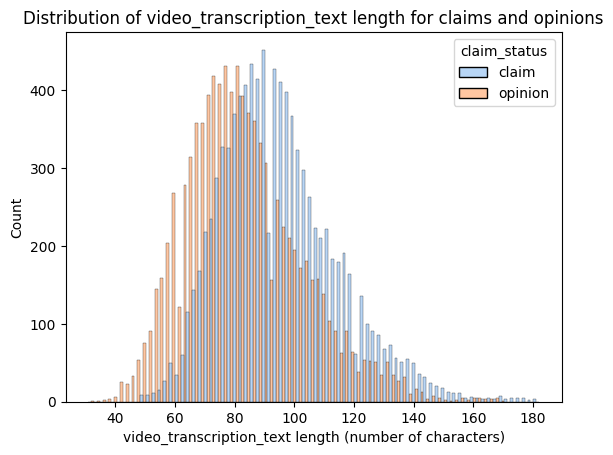

In [13]:
# Visualize the distribution of `text_length` for claims and opinions
sns.histplot(data=data, stat="count", multiple="dodge", x="text_length",
             kde=False, palette="pastel", hue="claim_status",
             element="bars", legend=True)
plt.xlabel("video_transcription_text length (number of characters)")
plt.ylabel("Count")
plt.title("Distribution of video_transcription_text length for claims and opinions")
plt.show()

Letter count distributions for both claims and opinions are approximately normal with a slight right skew. Claim videos tend to have more characters&mdash;about 13 more on average, as indicated in a previous cell.

**Feature selection and transformation**

In [14]:
# Encoding target and catgorical variables.
X = data.copy()
# Drop unnecessary columns
X = X.drop(['#', 'video_id'], axis=1)
# Encode target variable
X['claim_status'] = X['claim_status'].replace({'opinion': 0, 'claim': 1})
# Dummy encode remaining categorical values
X = pd.get_dummies(X,
                   columns=['verified_status', 'author_ban_status'],
                   drop_first=True,dtype=int)
X.head()

,claim_status,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,0,0,1
1,1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,0,0,0
2,1,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,0,0,0
3,1,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,0,0,0
4,1,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,0,0,0


**Tokenize text column**


In [15]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features=20,stop_words='english').fit(X['video_transcription_text'])

ngram_features = tfidf_vectorizer.transform(X['video_transcription_text'])
ngram_df = pd.DataFrame(ngram_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
X = pd.concat([X, ngram_df], axis=1).drop('video_transcription_text',axis=1)
print(X.shape)
X.head(2)

(19084, 31)


,claim_status,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,...,learned,media,news,online,read,revealed,view,website,willing,world
0,1,59,343296.0,19425.0,241.0,1.0,0.0,97,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,32,140877.0,77355.0,19034.0,1161.0,684.0,107,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### **Split the data**

In [16]:
# Isolate target variable
y = X['claim_status']

In [17]:
# Isolate features
X = X.drop(['claim_status'], axis=1)

# Display first few rows of features dataframe
X.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,learned,media,news,online,read,revealed,view,website,willing,world
0,59,343296.0,19425.0,241.0,1.0,0.0,97,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,32,140877.0,77355.0,19034.0,1161.0,684.0,107,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,31,902185.0,97690.0,2858.0,833.0,329.0,137,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,25,437506.0,239954.0,34812.0,1234.0,584.0,131,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,19,56167.0,34987.0,4110.0,547.0,152.0,128,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### **Create train/validate/test sets**

In [18]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [19]:
X_tr, X_val, y_tr, y_val = train_test_split( X_train, y_train, test_size=0.3,random_state=42)
split_index = [0 if x in X_val.index else -1 for x in X_train.index ]
custom_split= PredefinedSplit(split_index)

### **Build models**

### **Build a logistic regression model**


In [20]:
lr = LogisticRegression(penalty='l2', solver='liblinear')
lr.fit(X_train, y_train)
preds = lr.predict(X_train)
print(classification_report(y_train, preds))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7548
           1       1.00      0.98      0.99      7719

    accuracy                           0.99     15267
   macro avg       0.99      0.99      0.99     15267
weighted avg       0.99      0.99      0.99     15267



accuracy:  0.9895205658894419
precision:  1.0
recall:  0.9788247750132345
F1 score:  0.9892990904226859


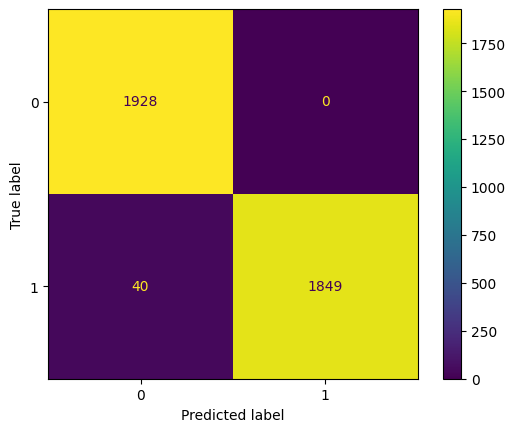

In [21]:
preds = lr.predict(X_test)
print('accuracy: ',accuracy_score(y_test,preds))
print('precision: ',precision_score(y_test,preds))
print('recall: ',recall_score(y_test,preds))
print('F1 score: ',f1_score(y_test,preds))
cm = confusion_matrix(y_test,preds)
ConfusionMatrixDisplay(cm).plot()

In [22]:
coef = list(zip(lr.feature_names_in_,(np.exp(lr.coef_[0])-1)))
coef.sort(key=lambda x: x[1],reverse=True)
len(coef),coef

(30,
 [('video_comment_count', 0.0015205019683468546),
  ('video_like_count', 0.00029497656965027375),
  ('video_download_count', 0.0001739517911620858),
  ('video_view_count', 0.0001457115101104467),
  ('claim', 2.984381660886548e-05),
  ('read', 2.8948619332780368e-05),
  ('learned', 2.4956347617122177e-05),
  ('discovered', 2.377759373461963e-05),
  ('friend', 2.3089107340057424e-05),
  ('colleague', 2.286156542385953e-05),
  ('media', 2.2675688285289652e-05),
  ('news', 1.704126034463016e-05),
  ('revealed', 8.81440357058949e-06),
  ('online', 7.83220707401e-06),
  ('website', 7.599197254570811e-06),
  ('forum', 7.159936070477713e-06),
  ('author_ban_status_banned', 2.7053366102869347e-06),
  ('internet', -1.4531007372919902e-06),
  ('author_ban_status_under review', -1.4448370738384675e-05),
  ('earth', -3.13071162243439e-05),
  ('world', -4.596402222356577e-05),
  ('willing', -6.319984265157341e-05),
  ('view', -6.383819412736358e-05),
  ('verified_status_verified', -7.9659312526

### **Build a random forest model**


Fit a random forest model to the training set. Use cross-validation to tune the hyperparameters and select the model that performs best on recall.

In [23]:
# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=0)


params = { 
            'max_features': Real(0.3,.9,prior='log-uniform'),
            'max_depth': Integer(2,20,prior='uniform'),
            'n_estimators': Integer(50,300,prior='uniform'),
            'max_samples': Real(.5,.9,prior='uniform'),
            'min_samples_leaf':Integer(1,5,prior='log-uniform'),
            'min_samples_split': Integer(2,10,prior='log-uniform')
        }
rf_cv =BayesSearchCV(rf,params,cv=custom_split,n_iter=10,n_jobs=-1,refit='recall')

In [24]:
%%time
rf_cv.fit(X_train, y_train)

CPU times: user 4.27 s, sys: 1.19 s, total: 5.45 s
Wall time: 26.1 s


BayesSearchCV(cv=PredefinedSplit(test_fold=array([ 0, -1, ...,  0,  0])),
              estimator=RandomForestClassifier(random_state=0), n_iter=10,
              n_jobs=-1, refit='recall',
              search_spaces={'max_depth': Integer(low=2, high=20, prior='uniform', transform='normalize'),
                             'max_features': Real(low=0.3, high=0.9, prior='log-uniform', transform='normalize'),
                             'max_samples': Real(low=0.5, high=0.9, prior='uniform', transform='normalize'),
                             'min_samples_leaf': Integer(low=1, high=5, prior='log-uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=10, prior='log-uniform', transform='normalize'),
                             'n_estimators': Integer(low=50, high=300, prior='uniform', transform='normalize')})

In [25]:
# Examine best recall score
rf_cv.best_score_

0.9986902423051736

In [26]:
# Examine best parameters
rf_cv.best_params_

OrderedDict([('max_depth', 17),
             ('max_features', 0.61287067140099),
             ('max_samples', 0.5199329334187042),
             ('min_samples_leaf', 1),
             ('min_samples_split', 9),
             ('n_estimators', 125)])

This model performs exceptionally well, with an average recall score of 0.995 across the five cross-validation folds. After checking the precision score to be sure the model is not classifying all samples as claims, it is clear that this model is making almost perfect classifications.

### **Build an XGBoost model**

In [27]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)
params = { 
            'learning_rate': Real(0.001,0.3,prior='log-uniform'),
            'max_depth': Integer(2,10,prior='uniform'),
            'min_child_weight': Integer(2,10,prior='uniform'),
            'n_estimators': Integer(50,1000,prior='uniform'),
            'reg_alpha':Real(0.0001,2,prior='log-uniform'),
            'reg_lambda': Real(0.0001,2,prior='log-uniform')
        }
xgb_cv =BayesSearchCV(xgb,params,cv=custom_split,n_iter=10,n_jobs=-1,refit='recall')

In [28]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: user 5.89 s, sys: 1.24 s, total: 7.13 s
Wall time: 21.4 s


BayesSearchCV(cv=PredefinedSplit(test_fold=array([ 0, -1, ...,  0,  0])),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, grow_policy=None,
                                      importance_type=None,...
                             'max_depth': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'min_child_weight': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=50, high=1000, prior='uniform', transform='normalize'),
                             'reg_alpha': Real(low=0.0001, high=2, prior='log-uniform', transform='normalize'),
                             'reg_lambda': Real(low=0.0001, high=2, prior='log-uniform', transform='normalize')})

In [29]:
xgb_cv.best_score_

0.9971621916612093

In [30]:
xgb_cv.best_params_

OrderedDict([('learning_rate', 0.01464725003603248),
             ('max_depth', 4),
             ('min_child_weight', 2),
             ('n_estimators', 510),
             ('reg_alpha', 0.490230477836152),
             ('reg_lambda', 1.3488501594741786)])

This model also performs exceptionally well. Although its recall score is very slightly lower than the random forest model's, its precision score is perfect.

## **PACE: Execute**

#### **Random forest**

In [31]:
# Use the random forest "best estimator" model to get predictions on the validation set
y_pred = rf_cv.best_estimator_.predict(X_test)

In [32]:
# Display the predictions on the validation set
y_pred

array([1, 0, 1, ..., 0, 1, 0])

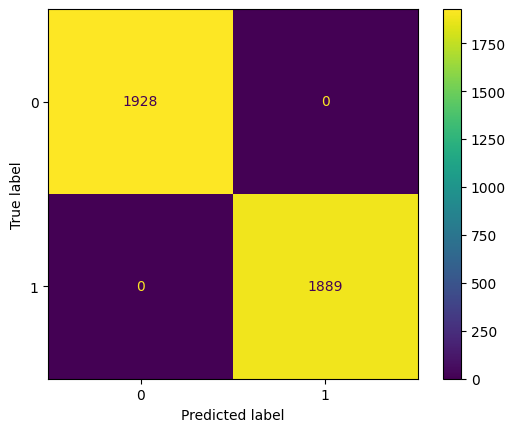

In [33]:
# Create a confusion matrix to visualize the results of the classification model

# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.show()

As the above confusion matrix shows, this model does not produce any false negatives.

In [34]:
# Create a classification report
# Create classification report for random forest model
target_labels = ['opinion', 'claim']
print(classification_report(y_test, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       1.00      1.00      1.00      1928
       claim       1.00      1.00      1.00      1889

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



#### **XGBoost**

In [35]:
#Evaluate XGBoost model
y_pred = xgb_cv.best_estimator_.predict(X_test)

In [36]:
y_pred

array([1, 0, 1, ..., 0, 1, 0])

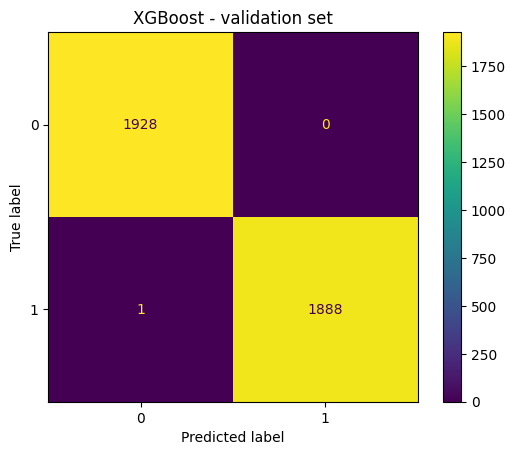

In [37]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('XGBoost - validation set');
plt.show()


In [38]:
# Create a classification report
target_labels = ['opinion', 'claim']
print(classification_report(y_test, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       1.00      1.00      1.00      1928
       claim       1.00      1.00      1.00      1889

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



The results of the XGBoost model were also nearly perfect. However, its errors tended to be false negatives. Identifying claims was the priority, so it's important that the model be good at capturing all actual claim videos. The random forest model has a better recall score, and is therefore the champion model.

#### **Feature importances of champion model**



In [41]:
importances = rf_cv.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test.columns)

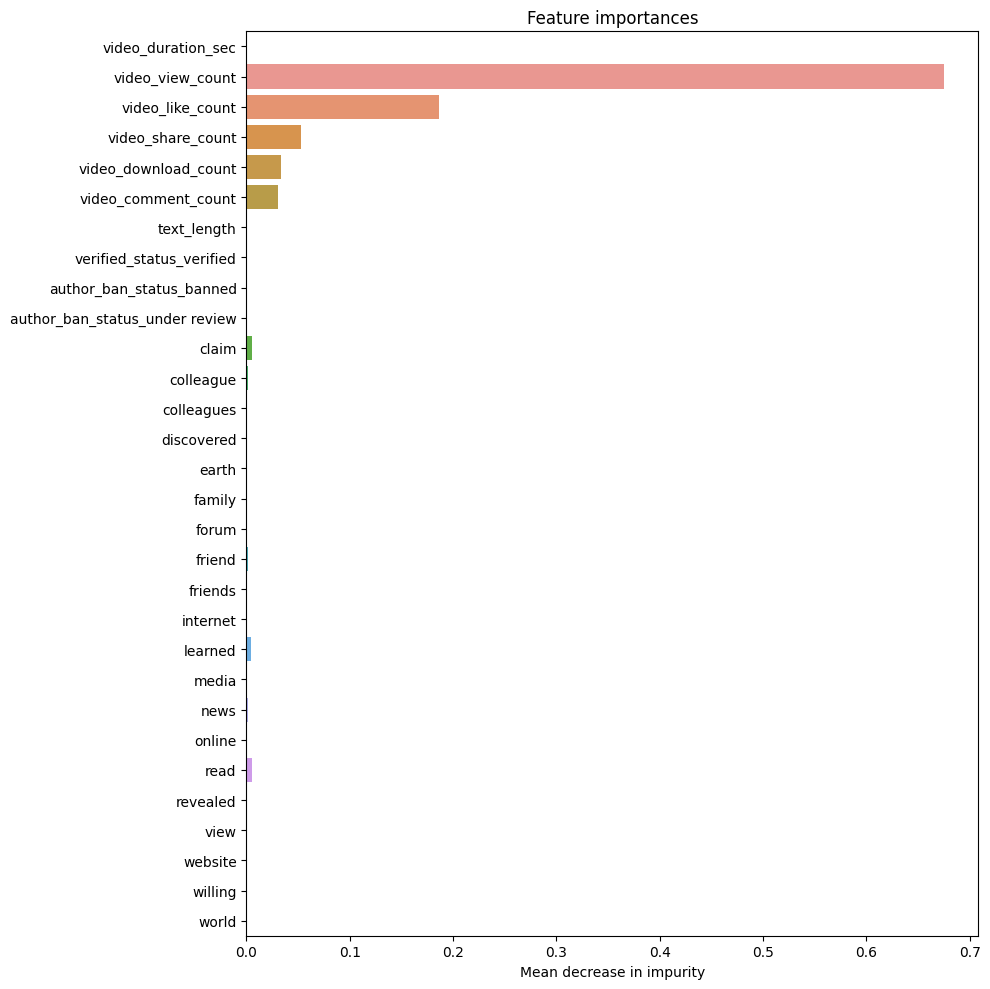

In [40]:
plt.figure(figsize=(10,10))
sns.barplot(x=rf_importances, y=rf_importances.index)
plt.title('Feature importances')
plt.xlabel('Mean decrease in impurity')
plt.tight_layout()